In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data

In [68]:
file_path = 'intel-aps/bin/scalapack/pdsyev/mpistatvsgs-si-10400-n4-np192-nt1/mpistats_vs_gridshape.h5'
store = pd.HDFStore(file_path)
print("Available aps-report:")
store.keys()

Available aps-report:


['/communicators',
 '/functions',
 '/mpi_msgsize',
 '/mpifunc_per_rank',
 '/transfer_per_communication',
 '/transfer_per_func',
 '/transfer_per_rank']

In [4]:
# Function summary of all ranks
df = store['functions']
df = df.sort_index().droplevel(1).reset_index()
df.columns = [col.strip() for col in df.columns]
df['Function'] = df['Function'].str.strip()
df_function = df.copy()

In [21]:
# MPI function time per rank
df = store['mpifunc_per_rank']
df = df.sort_index().droplevel(1).reset_index().sort_values(["index", "Rank"]).reset_index(drop=True)
df.columns = [col.strip() for col in df.columns]
df['Rank'] = df['Rank'].str.strip()
df_mpifunc_per_rank = df.copy()

In [25]:
# MPI message sizes
df = store['mpi_msgsize']
df = df.sort_index().droplevel(1).reset_index().sort_values(["index", "Message size(B)"]).reset_index(drop=True)
df.columns = [col.strip() for col in df.columns]
df['Message size(B)'] = df['Message size(B)'].str.strip()
df_mpi_msgsize = df.copy()

In [28]:
# Transfer per rank
df = store['transfer_per_rank']
df = df.sort_index().droplevel(1).reset_index().sort_values(["index", "Rank"]).reset_index(drop=True)
df.columns = [col.strip() for col in df.columns]
df['Rank'] = df['Rank'].str.strip()
df_transfer_per_rank = df.copy()

In [30]:
# Transfer per function
df = store['transfer_per_func']
df = df.sort_index().droplevel(1).reset_index()
df.columns = [col.strip() for col in df.columns]
df['Function'] = df['Function'].str.strip()
df_transfer_per_func = df.copy()
# df_transfer_per_func

In [35]:
# Transfer per communication from rank_a to rank_b
df = store['transfer_per_communication']
df = df.sort_index().droplevel(1).reset_index()
df.columns = [col.strip() for col in df.columns]
df['FromRank'] = df['FromRank'].str.strip()
df_transfer_per_communication = df.copy()
# df_transfer_per_communication

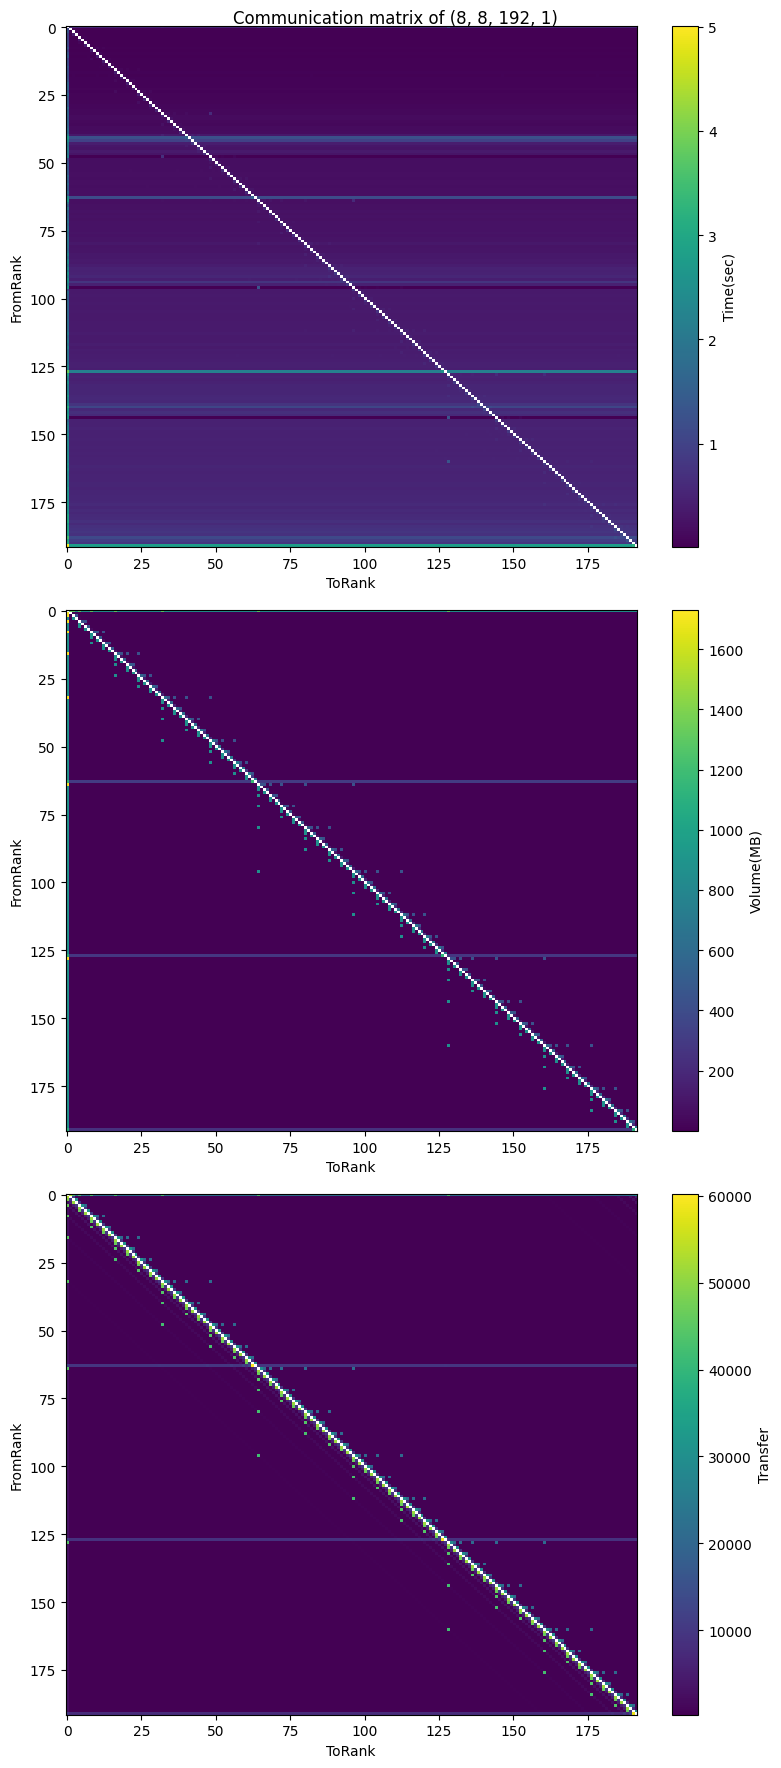

In [263]:
index = (8,8,192,1)
df = df_transfer_per_communication[df_transfer_per_communication["index"] == index]
df = df[~df['FromRank'].isin(['TOTAL', 'AVG'])]
df[['FromRank', 'ToRank']] = df[['FromRank', 'ToRank']].astype(int)

communication_matrix_time = df.pivot(index='FromRank', columns='ToRank', values='Time(sec)')
communication_matrix_volume = df.pivot(index='FromRank', columns='ToRank', values='Volume(MB)')
communication_matrix_transfers = df.pivot(index='FromRank', columns='ToRank', values='Transfers')

fig, axs = plt.subplots(3, 1, figsize=(8, 18))
fig.suptitle(f"Communication matrix of {index}")
# 
ax = axs[0]
matrix = communication_matrix_time.values
cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest', aspect='auto')
cbar = plt.colorbar(cax, label='Time(sec)')
# 
ax = axs[1]
matrix = communication_matrix_volume.values
cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest', aspect='auto')
cbar = plt.colorbar(cax, label='Volume(MB)')
# 
ax = axs[2]
matrix = communication_matrix_transfers.values
cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest', aspect='auto')
cbar = plt.colorbar(cax, label='Transfer')

for ax in axs:
    ax.set_xlabel('ToRank')
    ax.set_ylabel('FromRank')


plt.tight_layout()


# Analysis

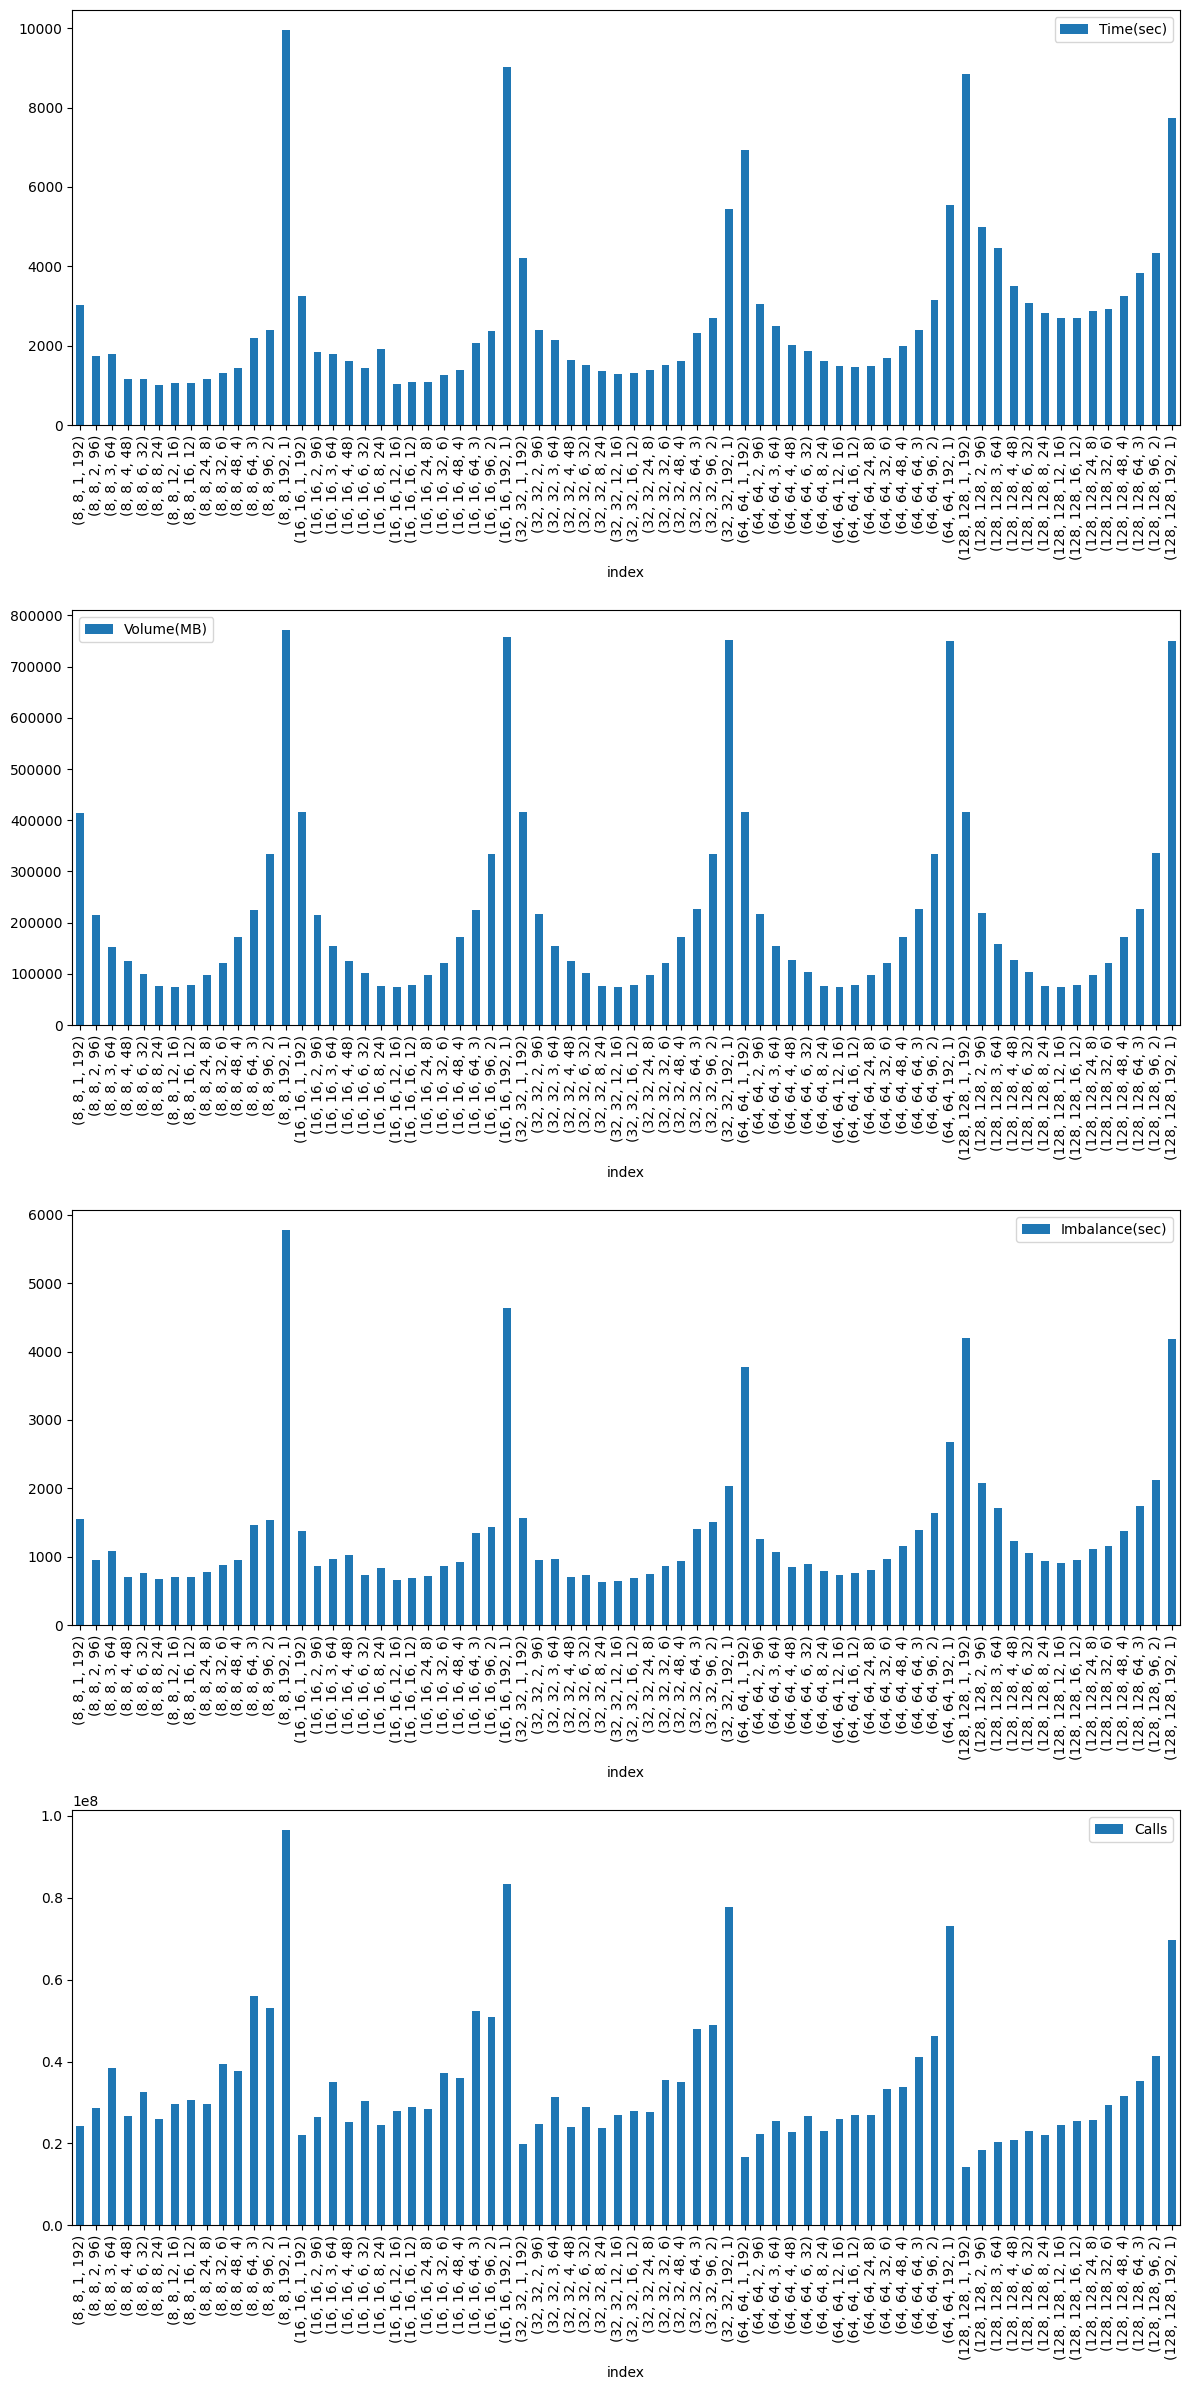

In [112]:
# Total values
df = df_function['Function'] == 'TOTAL'
df = df_function[df].reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(12, 24))

# Time
ax = axs[0]
df.plot(ax=ax, kind='bar', x='index', y='Time(sec)')

# Volume(MB) 
ax = axs[1]
df.plot(ax=ax, kind='bar', x='index', y='Volume(MB)')

# Imbalance 
ax = axs[2]
df.plot(ax=ax, kind='bar', x='index', y='Imbalance(sec)')

# Calls
ax = axs[3]
df.plot(ax=ax, kind='bar', x='index', y='Calls')

plt.tight_layout()

Two questions to answer:

- For a fixed block size, why best process grid is closest to square
    - Foucs on 8x8 data
- Why smaller block sizes outperform larger block sizes
    - Compare 8x8 with 128x128 data
 
Observatoins:

- Amount of data transfered for a process grid is independent of blocksize
- Imbalance metric follows time metric trend

Investigate sources of imbalance

- Which rank(s) are more problematic and why
- What functions cause the imbalance of those ranks

The following shows top 5 functions with largest data transfer for (8,8) blocksize. Inhomogeneous application of functions such as `MPI_Rsend` depending on the process grid can be seen

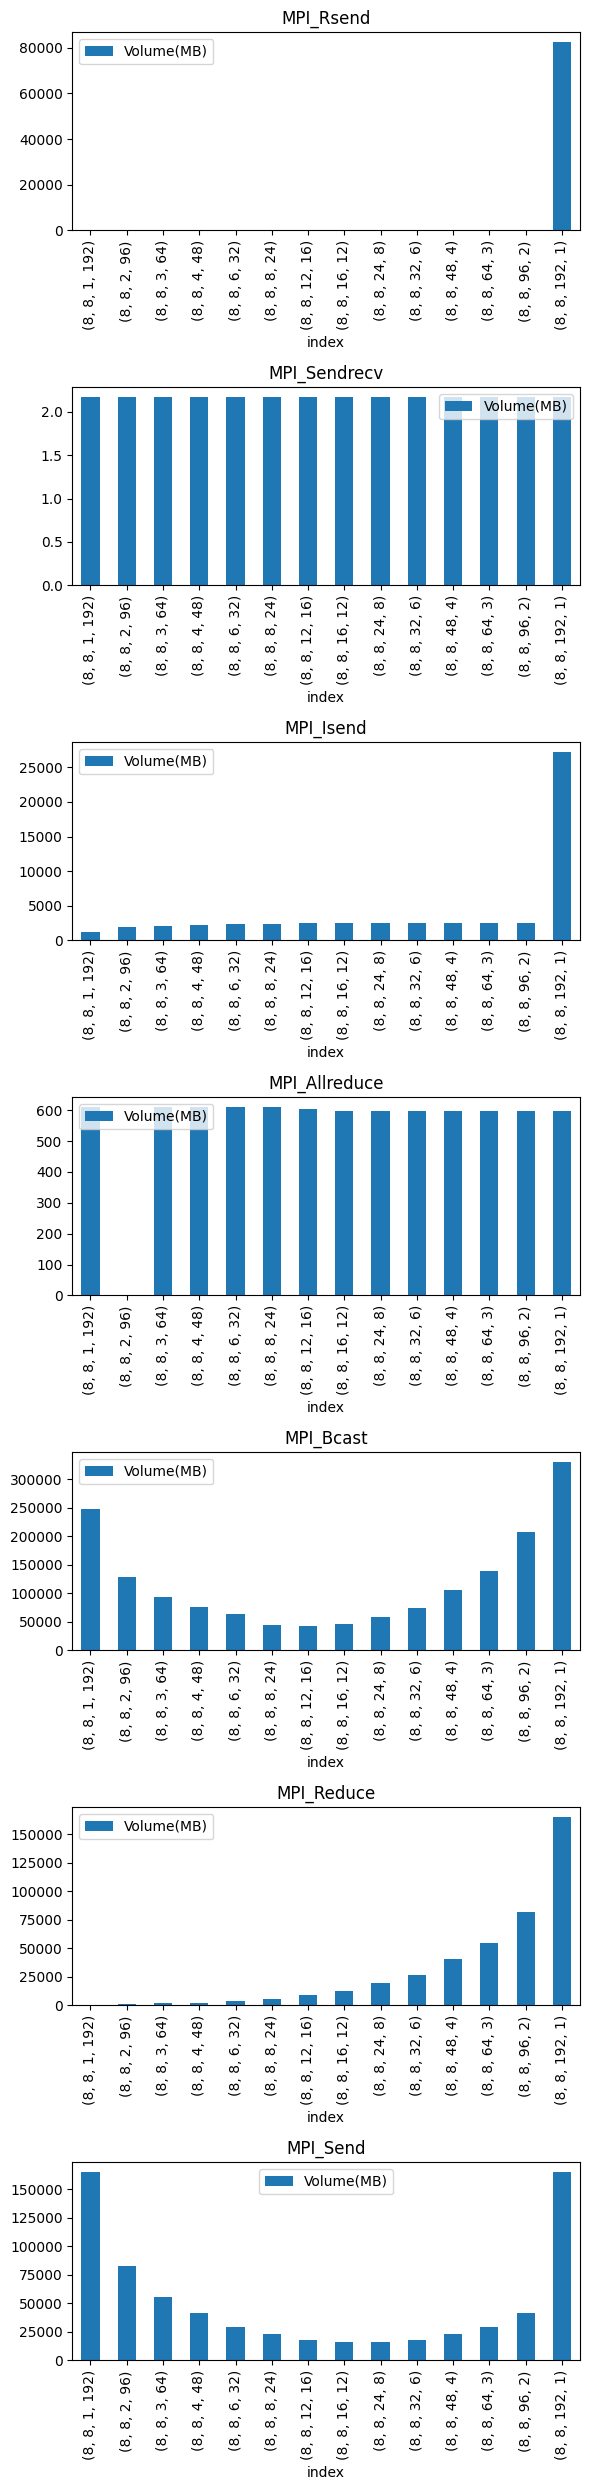

In [184]:
# 8x8 block
block_size = (8, 8)
df = df_transfer_per_func['index'].apply(lambda x: x[:2] == block_size)
df = df_transfer_per_func[df]
df = df[df['Function'] != 'TOTAL'] # remove total row
uniqe_index = df['index'].unique()

# Five function with largests volume for each process grid
largets_func = set()
for index in uniqe_index:
    # data for (mb,nb,p,q)
    df_tmp = df[df['index'] == index]        
    # idx_max = df_tmp['Volume(MB)'].idxmax()
    # max_func = df_tmp.loc[idx_max, 'Function']
    largets_func_tmp = df_tmp.nlargest(5, 'Volume(MB)')['Function']
    for f in largets_func_tmp.values:
        largets_func.add(f)

# Functions with largest volume
nfunc = len(largets_func)
fig, axs = plt.subplots(nfunc, 1, figsize=(6, 25))

for f, ax in zip(largets_func, axs):
    df[df['Function'] == f].plot(ax=ax, kind='bar', x="index", y="Volume(MB)")
    ax.set_title(f)
        
plt.tight_layout()

Here we can see which ranks are causing the imbalance behaviour

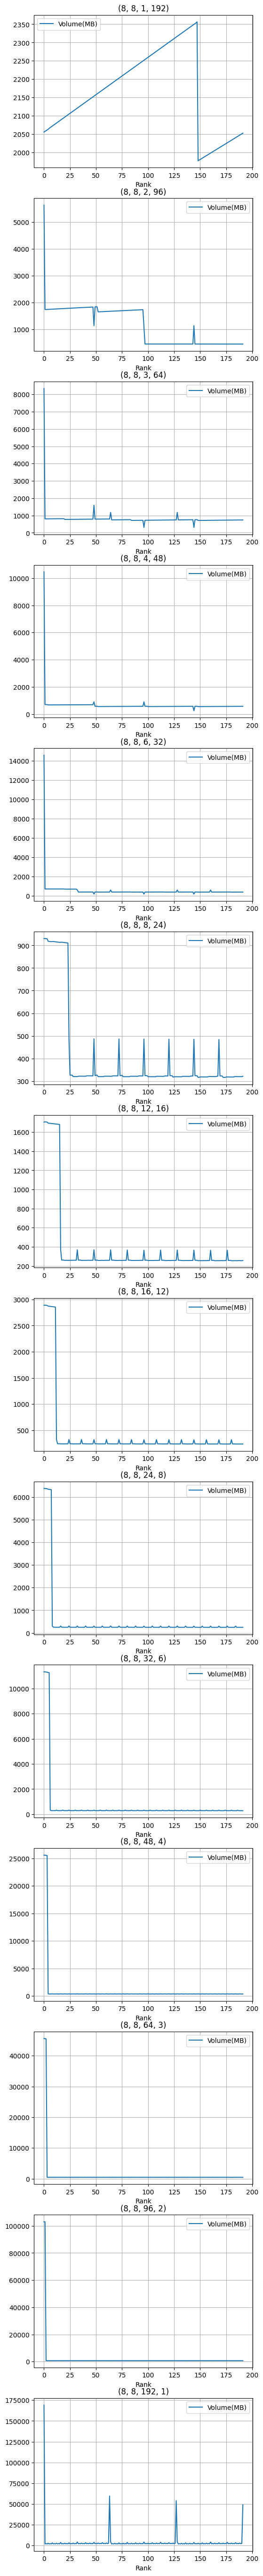

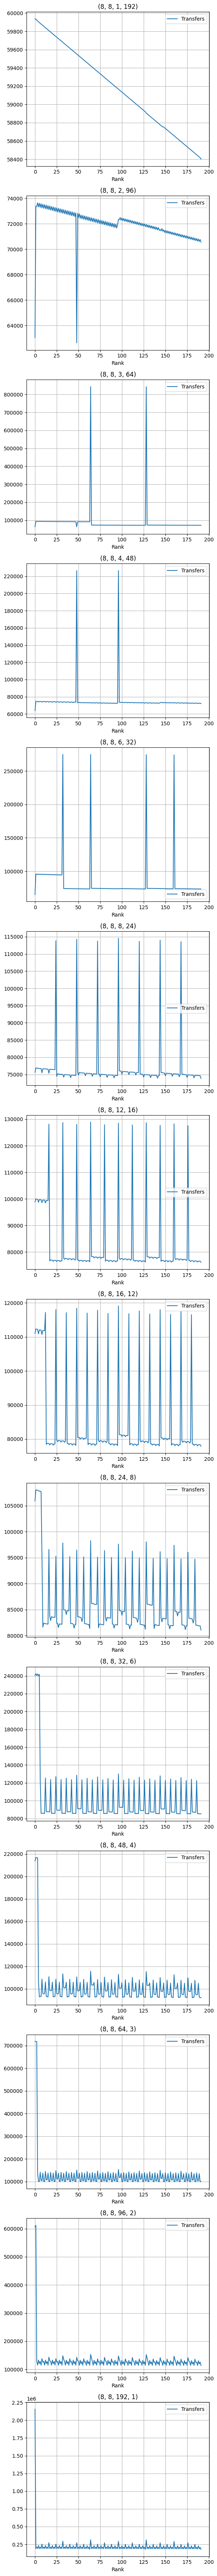

In [229]:
df = df_transfer_per_rank['index'].apply(lambda x: x[:2] == block_size)
df = df_transfer_per_rank[df]
df = df[~df['Rank'].isin(['TOTAL', 'AVG'])] # remove total and AVG row
df['Rank'] = df['Rank'].astype(int)
uniqe_index = df['index'].unique()

naxs = len(uniqe_index)
fig, axs = plt.subplots(naxs, 1, figsize=(6, 5*naxs))
for index, ax in zip(uniqe_index, axs):    
    df[df['index'] == index].plot(ax=ax, kind='line', x="Rank", y="Volume(MB)", style='-')
    ax.set_title(index)
    ax.grid()

naxs = len(uniqe_index)
fig, axs = plt.subplots(naxs, 1, figsize=(6, 5*naxs))
for index, ax in zip(uniqe_index, axs):    
    df[df['index'] == index].plot(ax=ax, kind='line', x="Rank", y="Transfers", style='-')
    ax.set_title(index)
    ax.grid()
        
plt.tight_layout()

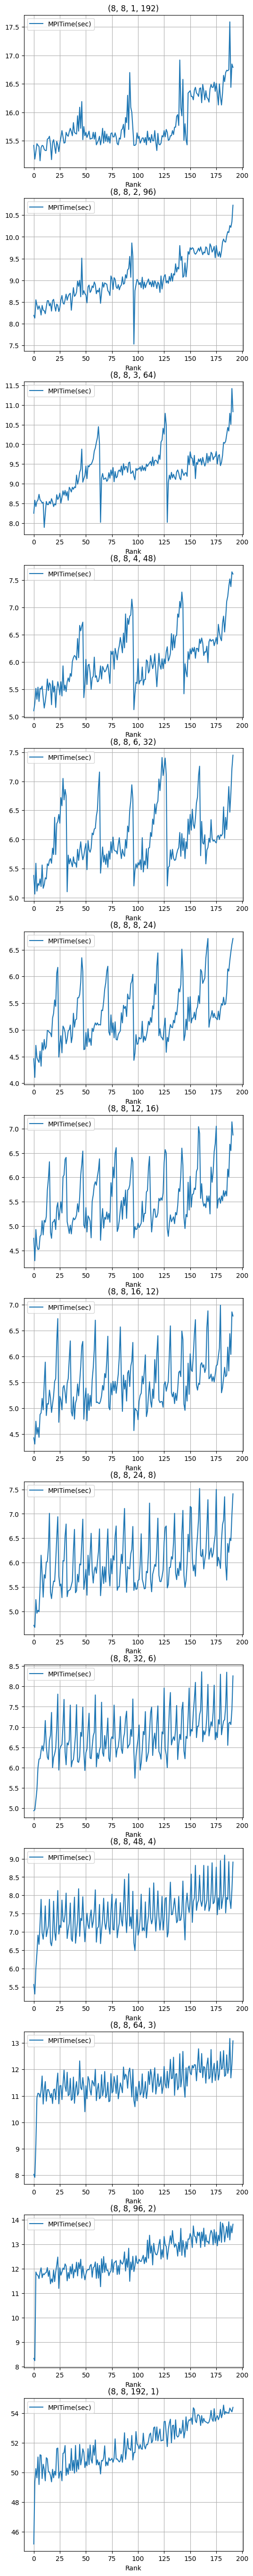

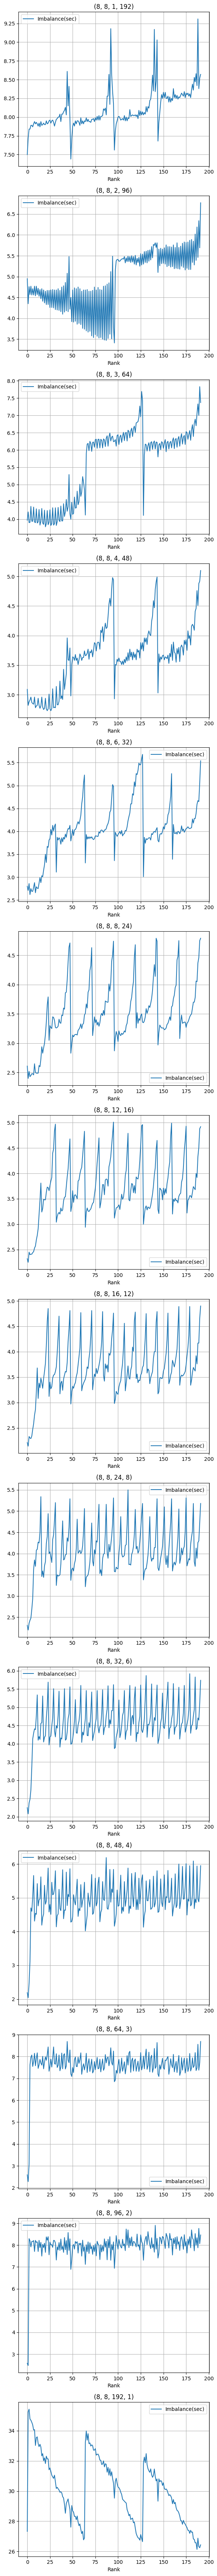

In [239]:

df = df_mpifunc_per_rank['index'].apply(lambda x: x[:2] == block_size)
df = df_mpifunc_per_rank[df]
df = df[~df['Rank'].isin(['TOTAL', 'AVG'])] # remove total and AVG row
df['Rank'] = df['Rank'].astype(int)
uniqe_index = df['index'].unique()

naxs = len(uniqe_index)
fig, axs = plt.subplots(naxs, 1, figsize=(6, 5*naxs))
for index, ax in zip(uniqe_index, axs):    
    df[df['index'] == index].plot(ax=ax, kind='line', x="Rank", y="MPITime(sec)", style='-')
    ax.set_title(index)
    ax.grid()
    
naxs = len(uniqe_index)
fig, axs = plt.subplots(naxs, 1, figsize=(6, 5*naxs))
for index, ax in zip(uniqe_index, axs):    
    df[df['index'] == index].plot(ax=ax, kind='line', x="Rank", y="Imbalance(sec)", style='-')
    ax.set_title(index)
    ax.grid()
        
plt.tight_layout()

,index,FromRank,ToRank,Time(sec),Volume(MB),Transfers
214445,"(8, 8, 12, 16)",0015,191.0,1.93,134.62,16566.0
241792,"(8, 8, 12, 16)",0159,191.0,1.58,0.02,7.0
244848,"(8, 8, 12, 16)",0175,191.0,1.57,0.02,709.0
235680,"(8, 8, 12, 16)",0127,191.0,1.56,0.06,1762.0
223613,"(8, 8, 12, 16)",0063,191.0,1.54,0.06,1763.0
226669,"(8, 8, 12, 16)",0079,191.0,1.54,0.02,7.0
229725,"(8, 8, 12, 16)",0095,191.0,1.54,0.31,8.0
232624,"(8, 8, 12, 16)",0111,191.0,1.54,0.02,61.0
217501,"(8, 8, 12, 16)",0031,191.0,1.51,0.05,1141.0
238736,"(8, 8, 12, 16)",0143,191.0,1.50,0.31,8.0


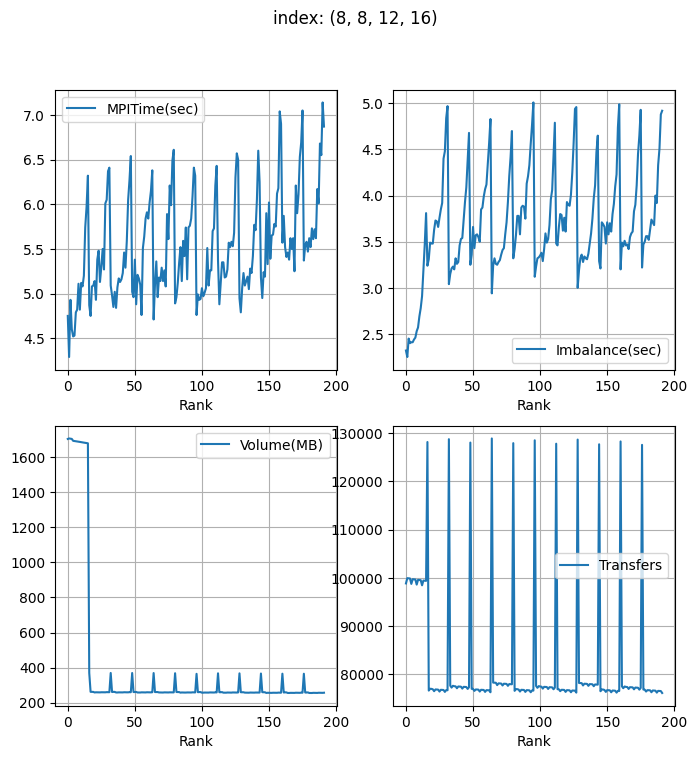

In [268]:
index = (8,8,12,16)

# 
df_time = df_mpifunc_per_rank['index'] == index
df_time = df_mpifunc_per_rank[df_time]
df_time = df_time[~df_time['Rank'].isin(['TOTAL', 'AVG'])] # remove total and AVG row
df_time['Rank'] = df_time['Rank'].astype(int)
# 
df_volume = df_transfer_per_rank['index'] == index
df_volume = df_transfer_per_rank[df_volume]
df_volume = df_volume[~df_volume['Rank'].isin(['TOTAL', 'AVG'])] # remove total and AVG row
df_volume['Rank'] = df_volume['Rank'].astype(int)

# 
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle(f"index: {index}")
# 
ax = axs[0,0]
df_time.plot(ax=ax, x='Rank', y='MPITime(sec)')
ax = axs[0,1]
df_time.plot(ax=ax, x='Rank', y='Imbalance(sec)')
# 
ax = axs[1,0]
df_volume.plot(ax=ax, x='Rank', y='Volume(MB)')
ax = axs[1,1]
df_volume.plot(ax=ax, x='Rank', y='Transfers')
for ax in axs.flatten():
    ax.grid()

rank = 191
df = df_transfer_per_communication['index'] == index
df = df_transfer_per_communication[df]
df[df['ToRank'] == rank].nlargest(10, 'Time(sec)')

In [119]:
df_transfer_per_communication

,index,FromRank,ToRank,Time(sec),Volume(MB),Transfers
0,"(8, 8, 1, 192)",0000,1.00,0.23,437.44,2832.0
1,"(8, 8, 1, 192)",0000,2.00,0.07,6.25,241.0
2,"(8, 8, 1, 192)",0000,3.00,0.07,6.25,240.0
3,"(8, 8, 1, 192)",0000,4.00,0.07,6.25,241.0
4,"(8, 8, 1, 192)",0000,5.00,0.07,6.25,240.0
...,...,...,...,...,...,...
2493861,"(128, 128, 192, 1)",0191,188.00,0.28,0.02,7.0
2493862,"(128, 128, 192, 1)",0191,189.00,0.28,2.62,5147.0
2493863,"(128, 128, 192, 1)",0191,190.00,0.68,875.84,51255.0
2493864,"(128, 128, 192, 1)",TOTAL,12881.89,749890.78,32329988.00,NaN


In [120]:
df_mpi_msgsize

,index,Message size(B),Volume(MB),Volume(%),Transfers,Time(sec),Time(%)
0,"(8, 8, 1, 192)",8,31.61,0.01,3972288,60.35,2.03
1,"(8, 8, 1, 192)",10,0.22,0.00,22272,0.95,0.03
2,"(8, 8, 1, 192)",192,7.27,0.00,37840,0.13,0.00
3,"(8, 8, 1, 192)",224,267.12,0.06,1193811,2.19,0.07
4,"(8, 8, 1, 192)",256,155.95,0.04,609168,1.17,0.04
...,...,...,...,...,...,...,...
36123,"(128, 128, 192, 1)",131072,194.25,0.03,1482,0.05,0.00
36124,"(128, 128, 192, 1)",262144,419.43,0.06,1600,0.07,0.00
36125,"(128, 128, 192, 1)",393216,613.42,0.08,1560,0.12,0.00
36126,"(128, 128, 192, 1)",10550992,163234.40,21.77,15552,368.98,6.59
